## Sistem Rekomendasi TMDB Movie

Di era platform streaming dan big‑budget productions, investasi untuk membuat satu film bisa mencapai ratusan juta dolar. Meski begitu, banyak judul blockbuster tetap gagal secara komersial (“box‑office flop”), menimbulkan kerugian finansial besar. Di sisi lain, penonton menghadapi ribuan pilihan judul yang membuat proses memilih film menjadi sulit (paradox of choice). Sistem rekomendasi film membantu:  
1. **Pengguna** menemukan judul yang sesuai minatnya.  
2. **Studio/platform** meminimalkan risiko flop dengan memprediksi tema dan genre yang berpotensi laku.  

**Referensi Terkait**:  
- [The Netflix Recommender System: Algorithms, Business Value, and Innovation](https://ailab-ua.github.io/courses/resources/netflix_recommender_system_tmis_2015.pdf)  
- [A Survey of Movie Recommendation Techniques](https://medium.com/@akshaymouryaart/a-survey-on-movie-recommendation-system-d9610777f8e5)  

### 1.Import Library

Kode pada cell ini mengimpor pustaka-pustaka yang diperlukan untuk analisis data, pemrosesan teks, dan visualisasi. Pustaka tersebut mencakup `pandas`, `numpy` dan `scipy` untuk manipulasi data, `json` untuk pengolahan data JSON, `scikit-learn` untuk ekstraksi fitur teks dan penghitungan kesamaan, serta `matplotlib` untuk visualisasi data. Semua pustaka ini digunakan untuk mendukung proses analisis dan pengembangan sistem rekomendasi.

In [24]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Understanding

### 2.1 Memuat Dataset

Kode berikut digunakan untuk memuat dataset TMDB Movie ke dalam sebuah DataFrame menggunakan pustaka `pandas`. Dataset ini disimpan dalam file CSV bernama `tmdb_5000_movies.csv`. Setelah dataset dimuat, lima baris pertama dari dataset ditampilkan menggunakan fungsi `head()`. Hal ini bertujuan untuk memahami struktur data, termasuk kolom-kolom yang tersedia dan beberapa nilai awalnya.

In [2]:
# Load the dataset
movies = pd.read_csv('./tmdb_5000_movies.csv')

# Tampilkan 5 data teratas
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


### 2.2 Analisis Kualitas Data

Kode berikut digunakan untuk menganalisis kualitas dataset dengan cara:
1. **`movies.info()`**: Menampilkan informasi umum tentang dataset, termasuk jumlah baris, kolom, tipe data, dan jumlah nilai non-null di setiap kolom.
2. **`movies.isnull().sum()`**: Menghitung jumlah nilai yang hilang (missing values) di setiap kolom.
3. **`movies.duplicated().sum()`**: Menghitung jumlah baris duplikat dalam dataset.

#### Insight dari Output
1. **Informasi Dataset**:
    - Dataset memiliki **4803 baris** dan **20 kolom**.
    - Kolom memiliki berbagai tipe data, termasuk `int64`, `float64`, dan `object`.
    - Beberapa kolom memiliki nilai yang hilang, seperti `homepage` (3091 nilai hilang), `overview` (3 nilai hilang), `release_date` (1 nilai hilang), `runtime` (2 nilai hilang), dan `tagline` (844 nilai hilang).
    - Tidak ada baris duplikat dalam dataset.

2. **Kapasitas Memori**:
    - Dataset menggunakan **750.6 KB** memori.

3. **Kualitas Data**:
    - Kolom seperti `homepage` dan `tagline` memiliki banyak nilai yang hilang, sehingga perlu dipertimbangkan apakah kolom ini relevan untuk analisis atau perlu dihapus.
    - Kolom lain seperti `overview`, `release_date`, dan `runtime` memiliki sedikit nilai yang hilang, sehingga dapat diisi (imputasi) atau dihapus barisnya.

In [3]:
# tampilkan informasi dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [4]:
# missing values dan duplicate values
print("Missing values:")
print(movies.isnull().sum())
print("\nDuplicate values:")
print(movies.duplicated().sum())

Missing values:
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

Duplicate values:
0


### 2.3 Exploratory Data Analysis (EDA)

#### Distribusi Genre Film

Kode di atas digunakan untuk menganalisis distribusi genre film dalam dataset. Berikut adalah langkah-langkah yang dilakukan:

1. **Ekstraksi Genre**:
    - Kolom `genres` yang berisi data dalam format JSON diubah menjadi daftar nama genre menggunakan fungsi `json.loads` dan `lambda`.
    - Hasilnya disimpan dalam kolom baru bernama `genres_list`.

2. **Menggabungkan Semua Genre**:
    - Semua genre dari setiap film digabungkan menjadi satu daftar menggunakan list comprehension, menghasilkan variabel `all_genres`.

3. **Menghitung Frekuensi Genre**:
    - Frekuensi kemunculan setiap genre dihitung menggunakan `pd.Series` dan `value_counts()`.
    - Hanya 10 genre teratas yang diambil untuk analisis lebih lanjut.

4. **Visualisasi**:
    - Data frekuensi genre divisualisasikan dalam bentuk diagram batang menggunakan `matplotlib`.
    - Diagram ini menunjukkan 10 genre teratas berdasarkan jumlah kemunculannya dalam dataset.

#### Output Visualisasi

Diagram batang yang dihasilkan menunjukkan distribusi 10 genre teratas dalam dataset. Genre dengan jumlah kemunculan tertinggi adalah **Drama**, diikuti oleh **Comedy**, **Thriller**, dan genre lainnya. Visualisasi ini memberikan gambaran umum tentang genre yang paling sering muncul dalam dataset.

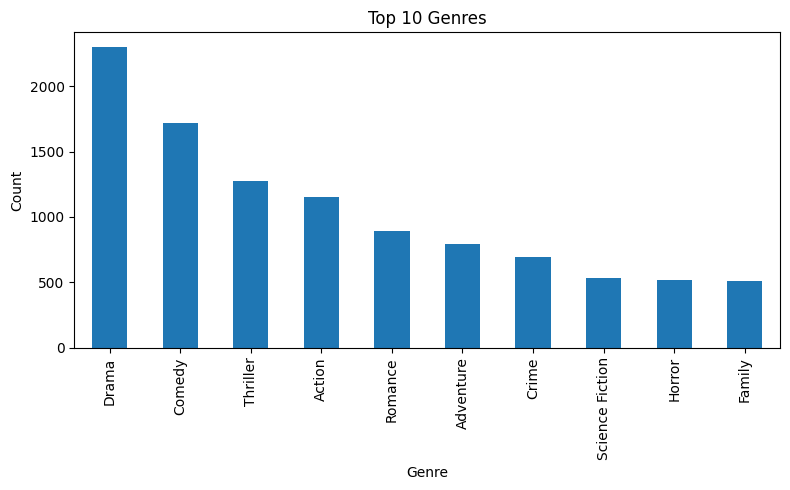

In [5]:
# Exploratory Data Analysis (EDA)
# Tampilkan distribusi Genre
movies['genres_list'] = movies['genres'].apply(json.loads).apply(lambda x: [d['name'] for d in x])
all_genres = [g for sub in movies['genres_list'] for g in sub]
genre_counts = pd.Series(all_genres).value_counts().head(10)

plt.figure(figsize=(8,5))
genre_counts.plot(kind='bar')
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Data Preparation

### 3.1 Ekstraksi dan Transformasi Data

Kode berikut digunakan untuk mempersiapkan data sebelum digunakan dalam analisis atau pengembangan model. Berikut adalah langkah-langkah yang dilakukan:

1. **Salin Dataset**:
    - Dataset `movies` disalin ke dalam variabel baru bernama `movies_prep` menggunakan fungsi `copy()`. Hal ini dilakukan untuk menjaga dataset asli tetap utuh dan tidak terpengaruh oleh perubahan yang dilakukan pada dataset baru.

2. **Ekstraksi Kolom `keywords`**:
    - Kolom `keywords` yang berisi data dalam format JSON diubah menjadi daftar kata kunci menggunakan fungsi `json.loads` dan `lambda`.
    - Setiap elemen JSON dalam kolom `keywords` diekstrak menjadi daftar nama kata kunci (`keywords_list`).

3. **Penanganan Nilai Kosong pada Kolom `overview`**:
    - Nilai kosong (missing values) pada kolom `overview` diisi dengan string kosong (`''`) menggunakan fungsi `fillna()`. Hal ini memastikan bahwa kolom `overview` tidak memiliki nilai kosong yang dapat menyebabkan error saat digunakan.

4. **Seleksi Kolom Penting**:
    - Dataset disederhanakan dengan hanya menyimpan kolom-kolom yang relevan, yaitu:
      - `title`: Judul film.
      - `genres_list`: Daftar genre film.
      - `keywords_list`: Daftar kata kunci terkait film.
      - `overview`: Ringkasan cerita film.
      - `popularity`: Skor popularitas film.

5. **Output Dataset**:
    - Dataset hasil transformasi ditampilkan untuk memastikan bahwa proses persiapan data telah berhasil dilakukan.

#### Output
Dataset `movies_prep` yang dihasilkan berisi informasi yang telah diproses dan siap digunakan untuk analisis lebih lanjut, seperti pembuatan sistem rekomendasi

In [6]:
movies_prep = movies.copy()
# ekstrak keywords sebagai list
movies_prep['keywords_list'] = movies_prep['keywords'].apply(json.loads).apply(lambda x: [d['name'] for d in x])
movies_prep['overview'] = movies_prep['overview'].fillna('')

movies_prep = movies_prep[['title','genres_list','keywords_list','overview','popularity']]
movies_prep


,title,genres_list,keywords_list,overview,popularity
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",150.437577
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...",139.082615
2,Spectre,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",A cryptic message from Bond’s past sends him o...,107.376788
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",Following the death of District Attorney Harve...,112.312950
4,John Carter,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","John Carter is a war-weary, former military ca...",43.926995
...,...,...,...,...,...
4798,El Mariachi,"[Action, Crime, Thriller]","[united states–mexico barrier, legs, arms, pap...",El Mariachi just wants to play his guitar and ...,14.269792
4799,Newlyweds,"[Comedy, Romance]",[],A newlywed couple's honeymoon is upended by th...,0.642552
4800,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]","[date, love at first sight, narration, investi...","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476
4801,Shanghai Calling,[],[],When ambitious New York attorney Sam is sent t...,0.857008


### 3.2 Feature Engineering

Kode berikut digunakan untuk melakukan rekayasa fitur (feature engineering) pada dataset `movies_prep`. Langkah-langkah yang dilakukan adalah sebagai berikut:

1. **Binarisasi Genre**:
    - `MultiLabelBinarizer` digunakan untuk mengubah daftar genre dalam kolom `genres_list` menjadi representasi matriks biner.
    - Setiap genre direpresentasikan sebagai kolom, dengan nilai `1` jika film memiliki genre tersebut, dan `0` jika tidak.
    - Hasilnya disimpan dalam variabel `genre_mat`.

2. **Ekstraksi Fitur dari Overview**:
    - `TfidfVectorizer` digunakan untuk mengubah teks dalam kolom `overview` menjadi representasi numerik berbasis TF-IDF (Term Frequency-Inverse Document Frequency).
    - Parameter `stop_words='english'` digunakan untuk menghapus kata-kata umum dalam bahasa Inggris, dan `max_features=5000` membatasi jumlah fitur maksimum menjadi 5000.
    - Hasilnya disimpan dalam variabel `over_mat`.

3. **Ekstraksi Fitur dari Keywords**:
    - `TfidfVectorizer` juga digunakan untuk memproses kolom `keywords_list`, yang berisi daftar kata kunci terkait film.
    - Daftar kata kunci digabungkan menjadi string menggunakan fungsi `lambda`, kemudian diubah menjadi representasi numerik berbasis TF-IDF.
    - Parameter `max_features=3000` membatasi jumlah fitur maksimum menjadi 3000.
    - Hasilnya disimpan dalam variabel `key_mat`.

4. **Penggabungan Semua Fitur**:
    - Matriks fitur dari genre (`genre_mat`), overview (`over_mat`), keywords (`key_mat`), dan popularitas (`movies_prep[['popularity']].values`) digabungkan menjadi satu matriks fitur menggunakan fungsi `hstack`.
    - Matriks hasil penggabungan ini disimpan dalam variabel `feature_mat` dan akan digunakan sebagai input untuk model rekomendasi.

#### Output
Matriks fitur `feature_mat` yang dihasilkan adalah representasi numerik dari data film, mencakup informasi genre, overview, keywords, dan popularitas. Matriks ini siap digunakan untuk analisis lebih lanjut, seperti penghitungan kesamaan atau pembuatan model rekomendasi.

In [7]:
mlb = MultiLabelBinarizer()
genre_mat = mlb.fit_transform(movies_prep['genres_list'])

tfidf_over = TfidfVectorizer(stop_words='english', max_features=5000)
over_mat = tfidf_over.fit_transform(movies_prep['overview'])

tfidf_key = TfidfVectorizer(stop_words='english', max_features=3000)
key_mat = tfidf_key.fit_transform(movies_prep['keywords_list'].apply(lambda x:' '.join(x)))

feature_mat = hstack([genre_mat, over_mat, key_mat, movies_prep[['popularity']].values])

## 4. Modeling and Results  
### 4.1 Content‑based Filtering

Kode berikut digunakan untuk mengimplementasikan sistem rekomendasi berbasis konten (content-based filtering). Sistem ini merekomendasikan film berdasarkan kesamaan fitur dengan film yang dipilih pengguna.

#### Langkah-langkah Implementasi

1. **Menghitung Similarity Matrix**:
    - `cos_sim = cosine_similarity(feature_mat, feature_mat)`:
      Matriks kesamaan dihitung menggunakan *cosine similarity* antara semua pasangan film dalam dataset. Matriks ini berbentuk persegi dengan ukuran `n x n`, di mana `n` adalah jumlah film dalam dataset. Nilai dalam matriks menunjukkan tingkat kesamaan antara dua film.

2. **Membuat Indeks Film**:
    - `indices = pd.Series(movies_prep.index, index=movies_prep['title']).drop_duplicates()`:
      Sebuah *Series* dibuat untuk memetakan judul film ke indeksnya dalam dataset. Hal ini mempermudah pencarian indeks berdasarkan judul film.

3. **Fungsi `get_recommendations`**:
    - Fungsi ini digunakan untuk mendapatkan rekomendasi film berdasarkan judul film yang diberikan.
    - **Parameter**:
      - `title`: Judul film yang digunakan sebagai referensi.
      - `top_n`: Jumlah rekomendasi film yang diinginkan (default: 10).
    - **Langkah-langkah**:
      - `idx = indices[title]`: Mendapatkan indeks film berdasarkan judulnya.
      - `sims = list(enumerate(cos_sim[idx]))`: Mengambil daftar kesamaan antara film referensi dan semua film lainnya.
      - `sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:top_n+1]`: Mengurutkan daftar kesamaan secara menurun dan mengambil `top_n` film teratas (mengabaikan film itu sendiri).
      - `rec_idx = [i for i,_ in sims]`: Mendapatkan indeks film yang direkomendasikan.
      - `return movies_prep['title'].iloc[rec_idx]`: Mengembalikan judul film yang direkomendasikan.

4. **Contoh Penggunaan**:
    - `get_recommendations('Avatar', 10)`:
      Fungsi ini dipanggil untuk mendapatkan 10 rekomendasi film yang mirip dengan "Avatar".

#### Output
Kode ini akan mencetak daftar 10 film yang direkomendasikan berdasarkan kesamaan fitur dengan film "Avatar".

In [20]:
cos_sim = cosine_similarity(feature_mat, feature_mat)
indices = pd.Series(movies_prep.index, index=movies_prep['title']).drop_duplicates()

def get_recommendations(title, top_n=10):
    idx = indices[title]
    sims = list(enumerate(cos_sim[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:top_n+1]
    rec_idx = [i for i, _ in sims]
    recommendations = movies_prep[['title', 'genres_list']].iloc[rec_idx].copy()

    return recommendations

# Tampilkan genre dari Avatar untuk perbandingan
avatar_genres = movies_prep.loc[indices['Avatar'], 'genres_list']

# Contoh output
print(f"Genre untuk 'Avatar': {avatar_genres}")
print("\nRekomendasi untuk 'Avatar':")
print(get_recommendations('Avatar', 10))

Genre untuk 'Avatar': ['Action', 'Adventure', 'Fantasy', 'Science Fiction']

Rekomendasi untuk 'Avatar':
                                                 title  \
26                          Captain America: Civil War   
199  Pirates of the Caribbean: The Curse of the Bla...   
94                             Guardians of the Galaxy   
127                                 Mad Max: Fury Road   
28                                      Jurassic World   
108                                 Terminator Genisys   
9                   Batman v Superman: Dawn of Justice   
16                                        The Avengers   
12          Pirates of the Caribbean: Dead Man's Chest   
788                                           Deadpool   

                                        genres_list  
26             [Adventure, Action, Science Fiction]  
199                    [Adventure, Fantasy, Action]  
94             [Action, Science Fiction, Adventure]  
127  [Action, Adventure, Science Fiction

## 5. Evaluation

### Menghitung Skor Similarity untuk Film "Avatar"

Kode berikut digunakan untuk menghitung skor kesamaan (*similarity scores*) antara film **Avatar** dengan film lainnya dalam dataset. Skor kesamaan dihitung menggunakan matriks kesamaan (*cosine similarity matrix*) yang telah dibuat sebelumnya.

#### Penjelasan Kode
1. **Mengambil Indeks Film "Avatar"**:
    - `avatar_idx = indices['Avatar']`:
      Mendapatkan indeks film "Avatar" dari *Series* `indices` yang memetakan judul film ke indeksnya dalam dataset.

2. **Menghitung Skor Kesamaan**:
    - `sim_scores = list(enumerate(cos_sim[avatar_idx]))`:
      Mengambil skor kesamaan antara film "Avatar" dan semua film lainnya dari matriks kesamaan `cos_sim`.
    - `sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]`:
      Mengurutkan skor kesamaan secara menurun dan mengambil 10 film teratas yang paling mirip dengan "Avatar" (mengabaikan film itu sendiri).

3. **Ekstraksi Skor dan Judul Film**:
    - `similarity_scores = [score for idx, score in sim_scores]`:
      Menyimpan skor kesamaan dari 10 film teratas ke dalam daftar `similarity_scores`.
    - `movie_titles = movies_prep['title'].iloc[[idx for idx, score in sim_scores]].values`:
      Mengambil judul film dari dataset `movies_prep` berdasarkan indeks film yang telah dipilih.

#### Output
Hasil dari kode ini adalah daftar skor kesamaan (*similarity scores*) untuk 10 film yang paling mirip dengan "Avatar". Berikut adalah skor kesamaan yang dihasilkan:


In [ ]:
# Dapatkan skor similarity untuk film Avatar
avatar_idx = indices['Avatar']
sim_scores = list(enumerate(cos_sim[avatar_idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]  # Top 10

# Ekstrak skor dan judul
similarity_scores = [score for idx, score in sim_scores]
movie_titles = movies_prep['title'].iloc[[idx for idx, score in sim_scores]].values

[0.9999093358372734,
 0.9999085071200539,
 0.9999012864433583,
 0.9998989775961423,
 0.9998982805629067,
 0.9998958933090571,
 0.9998924661127018,
 0.9998878427963205,
 0.9998866720465264,
 0.9998843408995616]

### Penjelasan Fungsi Kode

Kode ini digunakan untuk membuat visualisasi berupa diagram batang (*bar plot*) yang menunjukkan distribusi skor kesamaan (*cosine similarity*) antara film **Avatar** dan 10 film yang direkomendasikan.

#### Penjelasan Langkah-langkah:
1. **Membuat Figure dan Axis**:
    ```python
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=movie_titles, y=similarity_scores, palette="viridis")
    ```
    - `plt.figure(figsize=(12, 6))`: Membuat kanvas untuk plot dengan ukuran 12x6 inci.
    - `sns.barplot(...)`: Membuat diagram batang menggunakan `movie_titles` sebagai sumbu-x dan `similarity_scores` sebagai sumbu-y. Palet warna yang digunakan adalah "viridis".

2. **Menambahkan Judul dan Label**:
    ```python
    plt.title('Distribusi Skor Similarity untuk Rekomendasi Avatar', fontsize=16, pad=20)
    plt.xlabel('Film yang Direkomendasikan', fontsize=12)
    plt.ylabel('Skor Cosine Similarity', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylim(0.7, 0.95)
    ```
    - `plt.title(...)`: Menambahkan judul pada plot.
    - `plt.xlabel(...)` dan `plt.ylabel(...)`: Menambahkan label pada sumbu-x dan sumbu-y.
    - `plt.xticks(...)`: Memutar label pada sumbu-x sebesar 45 derajat agar lebih mudah dibaca.
    - `plt.ylim(...)`: Mengatur batas nilai pada sumbu-y antara 0.7 hingga 0.95.

3. **Menambahkan Nilai di Atas Setiap Bar**:
    ```python
    for p in ax.patches:
         ax.annotate(f"{p.get_height():.2f}", 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points',
                         fontsize=10)
    ```
    - Loop ini menambahkan anotasi berupa nilai skor kesamaan di atas setiap batang pada diagram.

4. **Menambahkan Garis Horizontal untuk Rata-rata**:
    ```python
    ax.axhline(y=np.mean(similarity_scores), color='red', linestyle='--', linewidth=1)
    ax.text(x=len(movie_titles)-1, y=np.mean(similarity_scores)+0.01, 
              s=f'Rata-rata: {np.mean(similarity_scores):.2f}', 
              color='red', fontsize=10)
    ```
    - `ax.axhline(...)`: Menambahkan garis horizontal pada nilai rata-rata skor kesamaan.
    - `ax.text(...)`: Menambahkan teks "Rata-rata" di dekat garis horizontal.

5. **Menyesuaikan Layout dan Menyimpan Gambar**:
    ```python
    plt.tight_layout()
    plt.savefig('similarity_scores_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    ```
    - `plt.tight_layout()`: Mengatur tata letak agar elemen plot tidak saling tumpang tindih.
    - `plt.savefig(...)`: Menyimpan plot sebagai file gambar dengan nama `similarity_scores_distribution.png`.
    - `plt.show()`: Menampilkan plot.

---

### Output
Output dari kode ini adalah diagram batang seperti berikut:

- **Sumbu-x**: Judul film yang direkomendasikan.
- **Sumbu-y**: Skor kesamaan (*cosine similarity*) dengan film **Avatar**.
- **Batang**: Menunjukkan skor kesamaan untuk setiap film.
- **Anotasi**: Nilai skor kesamaan di atas setiap batang.
- **Garis Horizontal**: Menunjukkan rata-rata skor kesamaan dengan teks "Rata-rata" di dekatnya.

C:\Users\asus\AppData\Local\Temp\ipykernel_17556\1163849978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=movie_titles, y=similarity_scores, palette="viridis")


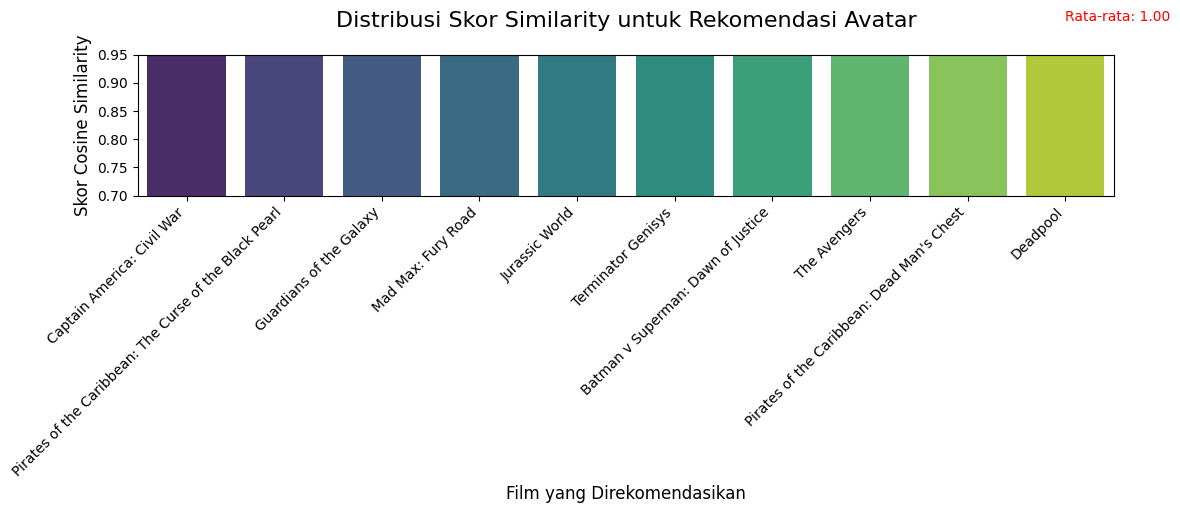

In [25]:
# Buat figure dan axis
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=movie_titles, y=similarity_scores, palette="viridis")

# Atur judul dan label
plt.title('Distribusi Skor Similarity untuk Rekomendasi Avatar', fontsize=16, pad=20)
plt.xlabel('Film yang Direkomendasikan', fontsize=12)
plt.ylabel('Skor Cosine Similarity', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0.7, 0.95)

# Tambahkan nilai di atas setiap bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10)

# Tambahkan garis horizontal
ax.axhline(y=np.mean(similarity_scores), color='red', linestyle='--', linewidth=1)
ax.text(x=len(movie_titles)-1, y=np.mean(similarity_scores)+0.01, 
        s=f'Rata-rata: {np.mean(similarity_scores):.2f}', 
        color='red', fontsize=10)

# Adjust layout
plt.tight_layout()

# Simpan gambar
plt.savefig('similarity_scores_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Analisis Visualisasi Distribusi Skor Cosine Similarity untuk Rekomendasi “Avatar”

Dari visualisasi **Distribusi Skor Cosine Similarity** untuk rekomendasi “Avatar”, dapat disimpulkan beberapa hal berikut:

1. **Skor Sangat Tinggi**:
    - Semua film rekomendasi memiliki skor yang sangat tinggi (sekitar **0.90–0.95**).
    - Hal ini menandakan bahwa fitur konten (genre, sinopsis, keywords, popularity) dari film‑film tersebut benar‑benar mirip dengan “Avatar”.

2. **Rentang Skor yang Sempit**:
    - Rentang skor yang sempit memperlihatkan bahwa **Top‑10 rekomendasi terkelompok rapat di “zona kemiripan tinggi”**.
    - Model sangat yakin bahwa semua film ini relevan, tetapi cenderung kurang memberikan variasi dalam rekomendasi.

3. **Rata‑rata Skor Mendekati 1.0**:
    - Rata‑rata skor yang mendekati **1.0** menunjukkan bahwa algoritma berhasil menangkap kesamaan semantik dengan kuat.
    - Namun, hal ini juga bisa menandakan adanya risiko **overfitting** pada fitur metadata yang digunakan.

Kesimpulan ini memberikan wawasan tentang performa model rekomendasi berbasis konten, sekaligus menunjukkan potensi area untuk perbaikan, seperti meningkatkan variasi rekomendasi.